# SageMaker Model Monitor - visualizing monitoring results


The prebuilt container from SageMaker computes a variety of statistics and evaluates constraints out of the box. This notebook demonstrates how you can visualize them. You can grab the ProcessingJob arn from the executions behind a MonitoringSchedule and use this notebook to visualize the results.

Let's import some python libraries that will be helpful for visualization

In [1]:
from IPython.display import HTML, display
import json
import os
import boto3

import sagemaker
from sagemaker import session
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader

## Get Utilities for Rendering

The functions for plotting and rendering distribution statistics or constraint violations are implemented in a `utils` file so let's grab that.

In [2]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

--2020-08-26 17:57:16--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12655 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  12.36K  --.-KB/s    in 0s      

2020-08-26 17:57:16 (91.2 MB/s) - ‘utils.py’ saved [12655/12655]



## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [3]:
processing_job_arn = 'arn:aws:sagemaker:us-east-1:668153774979:processing-job/model-monitoring-202008261700-ac0fda7470a280e9979429f9' 

In [4]:
execution = MonitoringExecution.from_processing_arn(sagemaker_session=session.Session(), processing_job_arn=processing_job_arn)
exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [5]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

## Overview

The code below shows the violations and constraint checks across all features in a simple table.

In [6]:
mu.show_violation_df(baseline_statistics=baseline_statistics, latest_statistics=execution_statistics, violations=violations)

,data_type,completeness,baseline_drift,categorical_values
edad,Integral,100.00%,N/A,N/A
edad_salario,Integral,100.00%,N/A,N/A
salario,Integral,100.00%,N/A,N/A
valor_gasto,Fractional,100.00%,14.01%,N/A


## Distributions

This section visualizes the distribution and renders the distribution statistics for all features

In [7]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
valor_gasto,2001,0,5.117489e+05,1.024009e+09,1.646744e+05,6.327019e+04,1.855736e+06
edad,2001,0,4.135732e+01,8.275600e+04,1.103557e+01,2.000000e+01,7.600000e+01
salario,2001,0,2.748007e+06,5.498762e+09,2.137670e+06,1.401100e+06,2.866000e+07
edad_salario,2001,0,1.170405e+08,2.341981e+11,1.057293e+08,3.080000e+07,1.518000e+09


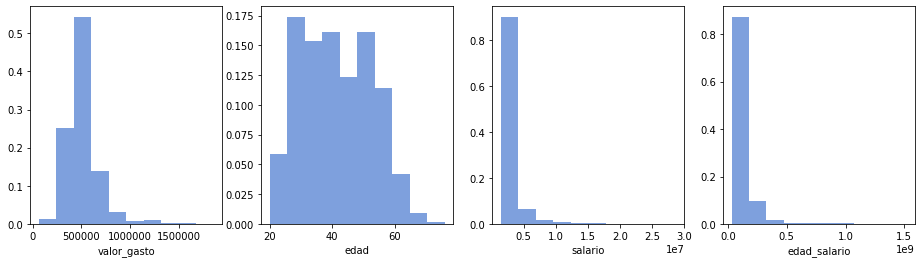

In [8]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
valor_gasto,2001,0,5.117489e+05,1.024009e+09,1.646744e+05,6.327019e+04,1.855736e+06
edad,2001,0,4.135732e+01,8.275600e+04,1.103557e+01,2.000000e+01,7.600000e+01
salario,2001,0,2.748007e+06,5.498762e+09,2.137670e+06,1.401100e+06,2.866000e+07
edad_salario,2001,0,1.170405e+08,2.341981e+11,1.057293e+08,3.080000e+07,1.518000e+09


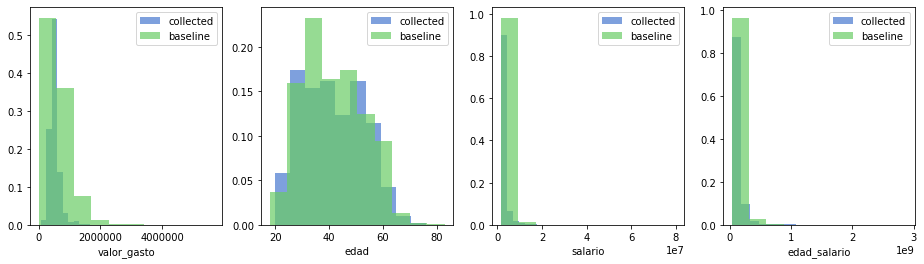

In [9]:
mu.show_distributions(features, feature_baselines)